<a href="https://colab.research.google.com/github/shoiTK/deep_learning_with_pytorch/blob/main/MyHRnetSeg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import logging
import functools
import numpy as np
import torch
import torch.nn as nn
import torch._utils
import torch.nn.functional as F

In [2]:
BatchNorm2d = nn.BatchNorm2d
BN_MOMENTUM = 0.01
logger = logging.getLogger(__name__)

def conv3x3(in_planes, out_planes, stride=1):
  return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)

class BasicBlock(nn.Module):
  expansion = 1
  def __init__(self, inplanes, planes, stride=1, downsample=None):
    super(BasicBlock, self).__init__()
    self.conv1 = conv3x3(inplanes, planes, stride)
    self.bn1 = BatchNorm2d(planes, momentum=BN_MOMENTUM)
    self.relu = nn.ReLU(inplace=False)
    self.conv2 = conv3x3(planes, planes)
    self.bn2 = BatchNorm2d(planes, momentum=BN_MOMENTUM)
    self.downsample = downsample
    self.stride = stride
  
  def forward(self, x):
    residual = x

    out = self.conv1(x)
    out = self.bn1(out)
    out = self.relu(out)

    out = self.conv2(out)
    out = self.bn2(out)

    if self.downsample is not None:
        residual = self.downsample(x)

    out = out + residual
    out = self.relu(out)

    return out


In [3]:
class Bottleneck(nn.Module):
  expansion = 4

  def __init__(self, inplanes, planes, stride=1, downsample=None):
    super(Bottleneck, self).__init__()
    self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
    self.bn1 = BatchNorm2d(planes, momentum=BN_MOMENTUM)
    self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
    self.bn2 = BatchNorm2d(planes, momentum=BN_MOMENTUM)
    self.conv3 = nn.Conv2d(planes, planes * self.expansion, kernel_size=1, bias=False)
    self.bn3 = BatchNorm2d(planes * self.expansion, momentum=BN_MOMENTUM)
    self.relu = nn.ReLU(inplace=False)
    self.downsample = downsample
    self.stride = stride
  
  def forward(self, x):
    residual = x

    out = self.conv1(x)
    out = self.bn1(out)
    out = self.relu(out)

    out = self.conv2(out)
    out = self.bn2(out)
    out = self.relu(out)

    out = self.conv3(out)
    out = self.bn3(out)

    if self.downsample is not None:
        residual = self.downsample(x)

    out = out + residual
    out = self.relu(out)

    return out


In [4]:
class HighResolutionModule(nn.Module):
    def __init__(self, num_branches, blocks, num_blocks, num_inchannels,
                 num_channels, fuse_method, multi_scale_output=True):
      super(HighResolutionModule, self).__init__()
      self._check_branches(num_branches, blocks, num_blocks, num_inchannels, num_channels)

      self.num_inchannels = num_inchannels
      self.fuse_method = fuse_method
      self.num_branches = num_branches

      self.multi_scale_output = multi_scale_output

      self.branches = self._make_branches(num_branches, blocks, num_blocks, num_channels)
      self.fuse_layers = self._make_fuse_layers()
      self.relu = nn.ReLU(inplace=False)

    def _check_branches(self, num_branches, blocks, num_blocks, num_inchannels, num_channels):
      if num_branches != len(num_blocks):
          error_msg = 'NUM_BRANCHES({}) <> NUM_BLOCKS({})'.format(num_branches, len(num_blocks))
          logger.error(error_msg)
          raise ValueError(error_msg)

      if num_branches != len(num_channels):
          error_msg = 'NUM_BRANCHES({}) <> NUM_CHANNELS({})'.format(num_branches, len(num_channels))
          logger.error(error_msg)
          raise ValueError(error_msg)

      if num_branches != len(num_inchannels):
          error_msg = 'NUM_BRANCHES({}) <> NUM_INCHANNELS({})'.format(num_branches, len(num_inchannels))
          logger.error(error_msg)
          raise ValueError(error_msg)

    def _make_one_branch(self, branch_index, block, num_blocks, num_channels, stride=1):
      downsample = None
      if stride != 1 or \
          self.num_inchannels[branch_index] != num_channels[branch_index] * block.expansion:
          downsample = nn.Sequential(
              nn.Conv2d(self.num_inchannels[branch_index],
                        num_channels[branch_index] * block.expansion,
                        kernel_size=1, stride=stride, bias=False),
              BatchNorm2d(num_channels[branch_index] * block.expansion,
                          momentum=BN_MOMENTUM),
          )

      layers = []
      layers.append(block(self.num_inchannels[branch_index],
                          num_channels[branch_index], stride, downsample))
      self.num_inchannels[branch_index] = \
          num_channels[branch_index] * block.expansion
      for i in range(1, num_blocks[branch_index]):
          layers.append(block(self.num_inchannels[branch_index],
                              num_channels[branch_index]))

      return nn.Sequential(*layers)

    def _make_branches(self, num_branches, block, num_blocks, num_channels):
      branches = []

      for i in range(num_branches):
          branches.append(
              self._make_one_branch(i, block, num_blocks, num_channels))

      return nn.ModuleList(branches)

    def _make_fuse_layers(self):
      if self.num_branches == 1:
          return None

      num_branches = self.num_branches
      num_inchannels = self.num_inchannels
      fuse_layers = []
      for i in range(num_branches if self.multi_scale_output else 1):
          fuse_layer = []
          for j in range(num_branches):
              if j > i:
                  fuse_layer.append(nn.Sequential(
                      nn.Conv2d(num_inchannels[j],
                                num_inchannels[i],
                                1,
                                1,
                                0,
                                bias=False),
                      BatchNorm2d(num_inchannels[i], momentum=BN_MOMENTUM)))
              elif j == i:
                  fuse_layer.append(None)
              else:
                  conv3x3s = []
                  for k in range(i-j):
                      if k == i - j - 1:
                          num_outchannels_conv3x3 = num_inchannels[i]
                          conv3x3s.append(nn.Sequential(
                              nn.Conv2d(num_inchannels[j],
                                        num_outchannels_conv3x3,
                                        3, 2, 1, bias=False),
                              BatchNorm2d(num_outchannels_conv3x3, 
                                          momentum=BN_MOMENTUM)))
                      else:
                          num_outchannels_conv3x3 = num_inchannels[j]
                          conv3x3s.append(nn.Sequential(
                              nn.Conv2d(num_inchannels[j],
                                        num_outchannels_conv3x3,
                                        3, 2, 1, bias=False),
                              BatchNorm2d(num_outchannels_conv3x3,
                                          momentum=BN_MOMENTUM),
                              nn.ReLU(inplace=False)))
                  fuse_layer.append(nn.Sequential(*conv3x3s))
          fuse_layers.append(nn.ModuleList(fuse_layer))

      return nn.ModuleList(fuse_layers)

    def get_num_inchannels(self):
      return self.num_inchannels

    def forward(self, x):
      if self.num_branches == 1:
          return [self.branches[0](x[0])]

      for i in range(self.num_branches):
          x[i] = self.branches[i](x[i])

      x_fuse = []
      for i in range(len(self.fuse_layers)):
          y = x[0] if i == 0 else self.fuse_layers[i][0](x[0])
          for j in range(1, self.num_branches):
              if i == j:
                  y = y + x[j]
              elif j > i:
                  width_output = x[i].shape[-1]
                  height_output = x[i].shape[-2]
                  y = y + F.interpolate(
                      self.fuse_layers[i][j](x[j]),
                      size=[height_output, width_output],
                      mode='bilinear')
              else:
                  y = y + self.fuse_layers[i][j](x[j])
          x_fuse.append(self.relu(y))

      return x_fuse

In [5]:
blocks_dict = {
    'BASIC': BasicBlock,
    'BOTTLENECK': Bottleneck
}

class HighResolutionNet(nn.Module):

    def __init__(self, config, **kwargs):
        #extra = config.MODEL.EXTRA
        extra = config['MODEL']['EXTRA']
        super(HighResolutionNet, self).__init__()

        # stem net
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1,
                               bias=False)
        self.bn1 = BatchNorm2d(64, momentum=BN_MOMENTUM)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1,
                               bias=False)
        self.bn2 = BatchNorm2d(64, momentum=BN_MOMENTUM)
        self.relu = nn.ReLU(inplace=False)

        self.stage1_cfg = extra['STAGE1']
        num_channels = self.stage1_cfg['NUM_CHANNELS'][0]
        block = blocks_dict[self.stage1_cfg['BLOCK']]
        num_blocks = self.stage1_cfg['NUM_BLOCKS'][0]
        self.layer1 = self._make_layer(block, 64, num_channels, num_blocks)
        stage1_out_channel = block.expansion*num_channels

        self.stage2_cfg = extra['STAGE2']
        num_channels = self.stage2_cfg['NUM_CHANNELS']
        block = blocks_dict[self.stage2_cfg['BLOCK']]
        num_channels = [
            num_channels[i] * block.expansion for i in range(len(num_channels))]
        self.transition1 = self._make_transition_layer(
            [stage1_out_channel], num_channels)
        self.stage2, pre_stage_channels = self._make_stage(
            self.stage2_cfg, num_channels)

        self.stage3_cfg = extra['STAGE3']
        num_channels = self.stage3_cfg['NUM_CHANNELS']
        block = blocks_dict[self.stage3_cfg['BLOCK']]
        num_channels = [
            num_channels[i] * block.expansion for i in range(len(num_channels))]
        self.transition2 = self._make_transition_layer(
            pre_stage_channels, num_channels)
        self.stage3, pre_stage_channels = self._make_stage(
            self.stage3_cfg, num_channels)

        self.stage4_cfg = extra['STAGE4']
        num_channels = self.stage4_cfg['NUM_CHANNELS']
        block = blocks_dict[self.stage4_cfg['BLOCK']]
        num_channels = [
            num_channels[i] * block.expansion for i in range(len(num_channels))]
        self.transition3 = self._make_transition_layer(
            pre_stage_channels, num_channels)
        self.stage4, pre_stage_channels = self._make_stage(
            self.stage4_cfg, num_channels, multi_scale_output=True)
        
        last_inp_channels = np.int(np.sum(pre_stage_channels))

        self.last_layer = nn.Sequential(
            nn.Conv2d(
                in_channels=last_inp_channels,
                out_channels=last_inp_channels,
                kernel_size=1,
                stride=1,
                padding=0),
            BatchNorm2d(last_inp_channels, momentum=BN_MOMENTUM),
            nn.ReLU(inplace=False),
            nn.Conv2d(
                in_channels=last_inp_channels,
                out_channels=config['NUM_CLASSES'],
                kernel_size=extra['FINAL_CONV_KERNEL'],
                stride=1,
                padding=1 if extra['FINAL_CONV_KERNEL'] == 3 else 0)
        )

    def _make_transition_layer(
            self, num_channels_pre_layer, num_channels_cur_layer):
        num_branches_cur = len(num_channels_cur_layer)
        num_branches_pre = len(num_channels_pre_layer)

        transition_layers = []
        for i in range(num_branches_cur):
            if i < num_branches_pre:
                if num_channels_cur_layer[i] != num_channels_pre_layer[i]:
                    transition_layers.append(nn.Sequential(
                        nn.Conv2d(num_channels_pre_layer[i],
                                  num_channels_cur_layer[i],
                                  3,
                                  1,
                                  1,
                                  bias=False),
                        BatchNorm2d(
                            num_channels_cur_layer[i], momentum=BN_MOMENTUM),
                        nn.ReLU(inplace=False)))
                else:
                    transition_layers.append(None)
            else:
                conv3x3s = []
                for j in range(i+1-num_branches_pre):
                    inchannels = num_channels_pre_layer[-1]
                    outchannels = num_channels_cur_layer[i] \
                        if j == i-num_branches_pre else inchannels
                    conv3x3s.append(nn.Sequential(
                        nn.Conv2d(
                            inchannels, outchannels, 3, 2, 1, bias=False),
                        BatchNorm2d(outchannels, momentum=BN_MOMENTUM),
                        nn.ReLU(inplace=False)))
                transition_layers.append(nn.Sequential(*conv3x3s))

        return nn.ModuleList(transition_layers)

    def _make_layer(self, block, inplanes, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                BatchNorm2d(planes * block.expansion, momentum=BN_MOMENTUM),
            )

        layers = []
        layers.append(block(inplanes, planes, stride, downsample))
        inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(inplanes, planes))

        return nn.Sequential(*layers)

    def _make_stage(self, layer_config, num_inchannels,
                    multi_scale_output=True):
        num_modules = layer_config['NUM_MODULES']
        num_branches = layer_config['NUM_BRANCHES']
        num_blocks = layer_config['NUM_BLOCKS']
        num_channels = layer_config['NUM_CHANNELS']
        block = blocks_dict[layer_config['BLOCK']]
        fuse_method = layer_config['FUSE_METHOD']

        modules = []
        for i in range(num_modules):
            # multi_scale_output is only used last module
            if not multi_scale_output and i == num_modules - 1:
                reset_multi_scale_output = False
            else:
                reset_multi_scale_output = True
            modules.append(
                HighResolutionModule(num_branches,
                                      block,
                                      num_blocks,
                                      num_inchannels,
                                      num_channels,
                                      fuse_method,
                                      reset_multi_scale_output)
            )
            num_inchannels = modules[-1].get_num_inchannels()

        return nn.Sequential(*modules), num_inchannels

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        #print(x.shape)
        x = self.layer1(x)
        #print(x.shape)
        x_list = []
        for i in range(self.stage2_cfg['NUM_BRANCHES']):
            if self.transition1[i] is not None:
                x_list.append(self.transition1[i](x))
            else:
                x_list.append(x)
        y_list = self.stage2(x_list)

        x_list = []
        for i in range(self.stage3_cfg['NUM_BRANCHES']):
            if self.transition2[i] is not None:
                if i < self.stage2_cfg['NUM_BRANCHES']:
                    x_list.append(self.transition2[i](y_list[i]))
                else:
                    x_list.append(self.transition2[i](y_list[-1]))
            else:
                x_list.append(y_list[i])
        y_list = self.stage3(x_list)

        x_list = []
        for i in range(self.stage4_cfg['NUM_BRANCHES']):
            if self.transition3[i] is not None:
                if i < self.stage3_cfg['NUM_BRANCHES']:
                    x_list.append(self.transition3[i](y_list[i]))
                else:
                    x_list.append(self.transition3[i](y_list[-1]))
            else:
                x_list.append(y_list[i])
        x = self.stage4(x_list)
        #print(x.shape)
        # Upsampling
        x0_h, x0_w = x[0].size(2), x[0].size(3)
        #x0_h, x0_w = x0_h* 4, x0_w * 2 
        #print(x0_h, x0_w)
        x1 = F.upsample(x[1], size=(x0_h, x0_w), mode='bilinear')
        x2 = F.upsample(x[2], size=(x0_h, x0_w), mode='bilinear')
        x3 = F.upsample(x[3], size=(x0_h, x0_w), mode='bilinear')

        x = torch.cat([x[0], x1, x2, x3], 1)

        x = self.last_layer(x)

        return x

    def init_weights(self, pretrained='',):
        logger.info('=> init weights from normal distribution')
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, std=0.001)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
        if pretrained:
            pretrained_dict = torch.load(pretrained)
            logger.info('=> loading pretrained model {}'.format(pretrained))
            model_dict = self.state_dict()
            pretrained_dict = {k: v for k, v in pretrained_dict.items()
                               if k in model_dict.keys()}
            for k, _ in pretrained_dict.items():
                logger.info(
                    '=> loading {} pretrained model {}'.format(k, pretrained))
            model_dict.update(pretrained_dict)
            self.load_state_dict(model_dict)

def get_seg_model(cfg, **kwargs):
    model = HighResolutionNet(cfg, **kwargs)
    model.init_weights(cfg['PRETRAINED'])

    return model

In [6]:
config = {}

config['NUM_CLASSES'] = 4
config['PRETRAINED'] = None

config['MODEL'] = {'EXTRA': {'FINAL_CONV_KERNEL': 1,
      'STAGE1': {'BLOCK': 'BOTTLENECK', 
                 'FUSE_METHOD': 'SUM',
                 'NUM_BLOCKS': [1],
                 'NUM_CHANNELS': [32],
                 'NUM_MODULES': 1,
                 'NUM_RANCHES': 1
                },
      'STAGE2': {'BLOCK': 'BASIC',
                 'FUSE_METHOD': 'SUM',
                 'NUM_BLOCKS': [2, 2],
                 'NUM_BRANCHES': 2,
                 'NUM_CHANNELS': [16, 32],
                 'NUM_MODULES': 1
                },
      'STAGE3':{'BLOCK': 'BASIC',
                'FUSE_METHOD': 'SUM',
                'NUM_BLOCKS': [2, 2, 2],
                'NUM_BRANCHES': 3,
                'NUM_CHANNELS': [16, 32, 64],
                'NUM_MODULES': 1
               },
       'STAGE4': {'BLOCK': 'BASIC',
                 'FUSE_METHOD': 'SUM',
                 'NUM_BLOCKS': [2, 2, 2, 2],
                 'NUM_BRANCHES': 4,
                 'NUM_CHANNELS': [16, 32, 64, 128],
                 'NUM_MODULES': 1
                 }}}

In [7]:
# model = get_seg_model(config)
# dump_input = torch.rand((1, 3, 256, 1600))
# output = model(dump_input)
# print(output.shape)

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader

In [9]:
def rectangle(img, img_ano, centers, max_side):
    """
    img     …四角形の線のみの2次元画像
    img_ano …あのーテーション画像
    centers …center座標のlist
    max_side…辺の最大長さの1/2 
    """
    if max_side < 3: #max_sideが小さすぎるとき
        max_side = 4
    #辺の長さの1/2を定義
    side_x = np.random.randint(3, int(max_side))
    side_y = np.random.randint(3, int(max_side))    

    #中心の座標,(x, y)を定義
    x = np.random.randint(max_side + 1, img.shape[0] - (max_side + 1))
    y = np.random.randint(max_side + 1, img.shape[1] - (max_side + 1))

    #過去の中心位置と近い位置が含まれた場合,inputデータをそのまま返す
    for center in centers:
        if np.abs(center[0] - x) < (2 *max_side + 1):
            if np.abs(center[1] - y) < (2 * max_side + 1):
                return img, img_ano, centers

    img[x - side_x : x + side_x, y - side_y] = 1.0      #上辺
    img[x - side_x : x + side_x, y + side_y] = 1.0      #下辺
    img[x - side_x, y - side_y : y + side_y] = 1.0      #左辺
    img[x + side_x, y - side_y : y + side_y + 1] = 1.0  #右辺
    img_ano[x - side_x : x + side_x + 1, y - side_y : y + side_y + 1] = 1.0
    centers.append([x, y])
    return img, img_ano, centers

In [10]:
num_images = 1000                                   #生成する画像数
length = 64                                          #画像のサイズ
imgs = np.zeros([num_images, 3, length, length])     #ゼロ行列を生成,入力画像
imgs_ano = np.zeros([num_images, 4, length, length]) #出力画像

for i in range(num_images):
    centers = []
    img = np.zeros([length, length])
    img_ano = np.zeros([64, 64])
    for j in range(6):                       #四角形を最大6つ生成
        img, img_ano, centers = rectangle(img, img_ano, centers, 12) 
    imgs[i, 0, :, :] = img
    imgs_ano[i, 0, :, :] = img_ano

imgs = torch.tensor(imgs, dtype = torch.float32)                 #ndarray - torch.tensor
imgs_ano = torch.tensor(imgs_ano, dtype = torch.float32)           #ndarray - torch.tensor
data_set = TensorDataset(imgs, imgs_ano)
data_loader = DataLoader(data_set, batch_size = 100, shuffle = True)

cuda


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2952: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


epoch: 0  loss: 0.2662581468001008
epoch: 1  loss: 0.07618886716663838
epoch: 2  loss: 0.02707645632326603
epoch: 3  loss: 0.01230123583227396
epoch: 4  loss: 0.006990068498998881
epoch: 5  loss: 0.004167435085400939
epoch: 6  loss: 0.0028742986731231214
epoch: 7  loss: 0.0020085266325622795
epoch: 8  loss: 0.0016138859442435204
epoch: 9  loss: 0.0011542945518158375
epoch: 10  loss: 0.0008545062504708767
epoch: 11  loss: 0.0006529596110340207
epoch: 12  loss: 0.00048390031734015795
epoch: 13  loss: 0.00037264601269271225
epoch: 14  loss: 0.0005007508269045502
epoch: 15  loss: 0.0004113345232326537
epoch: 16  loss: 0.0003546108724549413
epoch: 17  loss: 0.00038143926940392703
epoch: 18  loss: 0.00023580490233143792
epoch: 19  loss: 0.00015674761234549806
epoch: 20  loss: 0.00013475470695993862
epoch: 21  loss: 0.00016385447088396177
epoch: 22  loss: 0.00018907938356278465
epoch: 23  loss: 0.0001244914070412051
epoch: 24  loss: 0.00010457800744916313
epoch: 25  loss: 0.000161388046399224

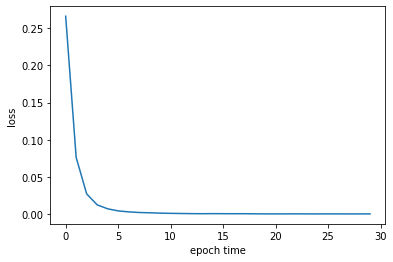

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
net = get_seg_model(config).to(device)                
loss_fn = nn.MSELoss()                                #損失関数の定義
optimizer = optim.Adam(net.parameters(), lr = 0.01)

losses = []                                     #epoch毎のlossを記録
epoch_time = 30

for epoch in range(epoch_time):
    running_loss = 0.0                          #epoch毎のlossの計算
    net.train()
    for i, (XX, yy) in enumerate(data_loader):
        optimizer.zero_grad()  
        XX = XX.to(device) 
        yy = yy.to(device)    
        y_pred = net(XX)
        loss = loss_fn(y_pred, yy)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print("epoch:",epoch, " loss:", running_loss/(i + 1))
    losses.append(running_loss/(i + 1))

#lossの可視化
plt.plot(losses)
plt.ylabel("loss")
plt.xlabel("epoch time")
plt.savefig("loss_auto")
plt.show()

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2952: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


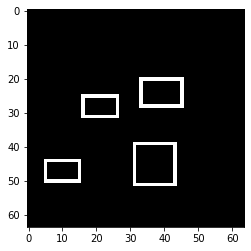

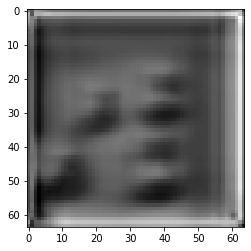

[]

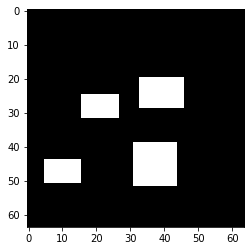

In [14]:
net.eval()            #評価モード
#今まで学習していない画像を1つ生成
num_images = 1
img_test = np.zeros([num_images, 3, length, length])
imgs_test_ano = np.zeros([num_images, 4, length, length])
for i in range(num_images):
    centers = []
    img = np.zeros([length, length])
    img_ano = np.zeros([length, length])
    for j in range(6):
        img, img_ano, centers = rectangle(img, img_ano, centers, 7)
    img_test[i, 0, :, :] = img

img_test = img_test.reshape([1, 3, 64, 64])
img_test = torch.tensor(img_test, dtype = torch.float32).to(device)
img_test = net(img_test).to(device)             #生成した画像を学習済のネットワークへ
img_test = img_test.cpu().detach().numpy() #torch.tensor - ndarray
img_test = img_test[0, 0, :, :]

plt.imshow(img, cmap = "gray")       #inputデータの可視化
plt.savefig("input_auto")
plt.show()
plt.imshow(img_test, cmap = "gray")  #outputデータの可視化
plt.savefig("output_auto")
plt.show()
plt.imshow(img_ano, cmap = "gray")   #正解データ
plt.savefig("correct_auto")
plt.plot()
